In [2]:
import scipy.interpolate

In [3]:
from matplotlib import pyplot as plt

In [4]:
import numpy as np

In [5]:
import cv2

In [6]:
image_trans = cv2.imread("cc96e68f4f452769d75d656ca65c1f1c.jpg",0)
image_trans = np.asanyarray(image_trans)
cv2.imshow("Image",image_trans)
cv2.waitKey()
print(image_trans.shape)
print(type(image_trans))
print(image_trans)

(314, 236)
<class 'numpy.ndarray'>
[[ 83  84  84 ... 106 107 107]
 [ 84  84  84 ... 106 107 108]
 [ 85  85  86 ... 107 107 108]
 ...
 [136 137 138 ... 154 153 153]
 [136 137 138 ... 152 151 151]
 [136 137 138 ... 152 151 151]]


In [7]:
k = 26
print(bin(k))
print(bin(k)[2:].zfill(8))

0b11010
00011010


In [8]:
#bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
#print(image_trans)
binary_image = []
for i in image_trans:
    x = np.array([bin(k)[2:].zfill(8) for k in i])
    for pixel in x:
        for bit in pixel:
            binary_image.append(int(bit))
print(len(binary_image))
bits = np.array(binary_image)
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean of bits (should be around 0.5): ", np.mean(bits))

592832
Bits count:  592832
First 20 bits:  [0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1]
Mean of bits (should be around 0.5):  0.49939274533088635


In [9]:
#K = 400521 # number of OFDM subcarriers
#K = 404089
print("number of symbols:  ", len(bits)/4)
K = int(len(bits)/4 + 9)

number of symbols:   148208.0


In [10]:
CP = K//4  # length of the cyclic prefix: 25% of the block

In [11]:
#P = 3576 # number of pilot carriers per OFDM block
P = 8
pilotValue = 3+3j # The known value each pilot transmits

allCarriers:   [     0      1      2 ... 148214 148215 148216]
pilotCarriers: [     0  18527  37054  55581  74108  92635 111162 129689 148216 148216]
dataCarriers:  [     1      2      3 ... 148213 148214 148215]


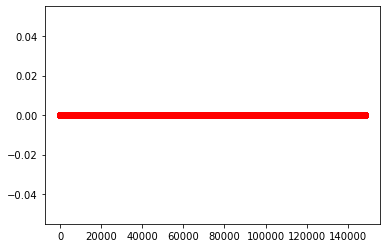

In [12]:
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')


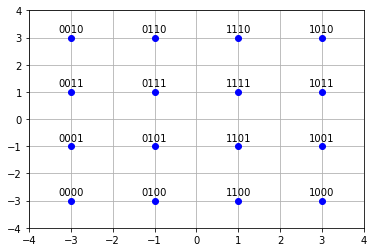

In [13]:
mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.grid(True)
                plt.xlim(-4,4)
                plt.ylim(-4,4)
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

In [14]:
demapping_table = {v : k for k, v in mapping_table.items()}

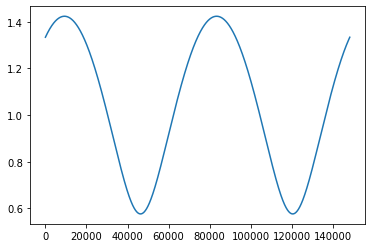

In [19]:
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))

SNRdb = 10  # signal to noise-ratio in dB at the receiver 

In [20]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))
bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])

First 5 bit groups
[[0 1 0 1]
 [0 0 1 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]]


In [21]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

First 5 QAM symbols and bits:
[[0 1 0 1]
 [0 0 1 1]
 [0 1 0 1]
 [0 1 0 0]
 [0 1 0 1]]
[-1.-1.j -3.+1.j -1.-1.j -1.-3.j -1.-1.j]


In [22]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM sub carriers in frequency domain: ", len(OFDM_data))

Number of OFDM sub carriers in frequency domain:  148217


In [23]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

Number of OFDM samples in time-domain before CP:  148217


In [24]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

Number of OFDM samples in time domain with CP:  185271


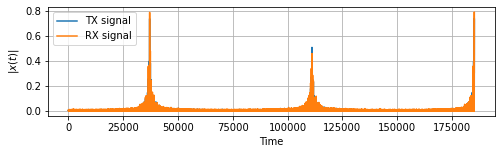

In [25]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [26]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [27]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

<ipython-input-28-9858d111f114>:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')


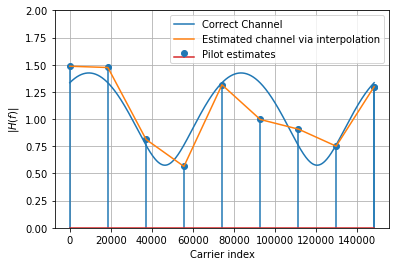

In [28]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
Hest = channelEstimate(OFDM_demod)

In [29]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)

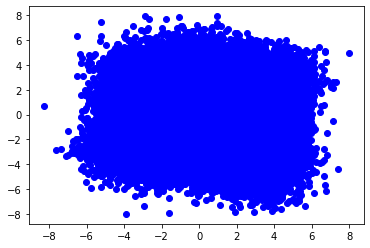

In [30]:
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)
plt.plot(QAM_est.real, QAM_est.imag, 'bo');

In [31]:
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, hardDecision = Demapping(QAM_est)
#for qam, hard in zip(QAM_est, hardDecision):
  #  plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    #plt.plot(hardDecision.real, hardDecision.imag, 'ro')

In [32]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)
print(bits_est)
print(len(bits_est))
#PSNR evaluate

[1 1 0 ... 1 1 1]
592832


In [33]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.0972467748029796


In [34]:
recei_image = []
k = 0
pixel_rec = ""
for bit_rec in bits_est:
    pixel_rec = pixel_rec + str(bit_rec)
    k = k + 1
    if k == 8:
        recei_image.append(int(pixel_rec,2))
        pixel_rec = ""
        k = 0
rec_image = np.asanyarray(recei_image, dtype=np.uint8)
rec_image = np.reshape(rec_image, (314, 236))
print(type(rec_image[1][1]))
print(rec_image)
cv2.imshow("receiver", rec_image)
cv2.waitKey()

<class 'numpy.uint8'>
[[211  84  84 ... 110 105 111]
 [ 85  92  84 ... 122 111 105]
 [ 85  69  82 ...  59 111 104]
 ...
 [136 137 138 ... 154 155 153]
 [136 137 138 ... 152 151 151]
 [136 137 138 ... 152 151 151]]


-1